In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
import skimage.io as io
import skimage.transform as tr
import skimage.color
import dask.array as da
from glob import glob
from dask.array.image import imread
from skimage import img_as_ubyte

Using TensorFlow backend.


In [2]:
def read_img(path, size):
    img = io.imread(path)
    img = tr.resize(img, size)
    img_as_ubyte(img)
    return img

def read_imgs(path, size):
    imgs = []
    paths = glob(path)
    index = 0
    for p in paths:
        img = read_img(p, size)
        imgs.append(img)
        index += 1
        if (index % 200 == 0):
            print(index)
    return np.array(imgs)


# Reads the images from a path, iterating over all images
# - resizing them to a 1 channel grayscale image
# - saving all images in a numpy array, returns this array 
def read_masks(path, size):
    imgs = []
    paths = glob(path)
    index = 0
    for p in paths:
        
        mask1 = read_img(p, (224,224,1))
        mask1 = np.array(mask1)
        mask1[mask1[:,:,0] > 0.001] = 1
        #mask1[mask1 > 0.01] = 1
        
        p2 = p.replace("masks_01","masks_02")
        mask2 = read_img(p2, (224,224,1))
        mask2 = np.array(mask2)
        mask2[mask2[:,:,0] > 0.001] = 1
        
        
        #black = np.zeros((224,224,1))
        #black[black[:,:,0] == 0] = 1
        #black[(mask1[:,:,0] == 1)|(mask2[:,:,0] == 1)] = 0
        
        
        if (index == 4):
            arr1 = np.zeros((224,224,1))
            arr2 = np.zeros((224,224,1))
            neu = np.zeros((224,224,1))
            
            neu = np.concatenate([arr1,arr2,mask2], axis=2)
            io.imsave('teeeeest.png',neu)
            print('Done')
        

        #p3 = p.replace("masks_03","masks_02")
        #print(p3)
        #mask3 = read_img(p3, (224,224,1))
        
        masks = np.concatenate([mask1, mask2], axis=2)
        
        imgs.append(masks)
        index += 1
        if (index % 200 == 0):
            print(index)
    return np.array(imgs)

# Saves the data into a variable (x = input, y = masks / ground truth)
x = None
x = read_imgs('/home/dan/Desktop/combined_masks/images/data/*.png', (224,224,1))
y = None
y = read_masks('/home/dan/Desktop/combined_masks/masks_01/data/*.png', (224,224,1))

/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000


/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: teeeeest.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Done
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000


In [3]:
mask_train = tf.keras.utils.to_categorical(y,2)

In [90]:
print(y.shape)
print(y.shape[0])

test = y.reshape(y.shape[0],-1,y.shape[3])
print(test.shape)

u = test.reshape((3064,224,224,2))


(3064, 224, 224, 2)
3064
(3064, 50176, 2)


In [4]:
print (mask_train.shape)

(3064, 224, 224, 2, 2)


In [3]:
def showImage(img, title=None, cmap=None):
    
    if (title != None):
        plt.title(title)
        
    plt.imshow(img[:,:,0], cmap = cmap)
    plt.show()    


def showImageFromArray(arr, i, title=None, cmap=None):
    showImage(arr[i],title,cmap)

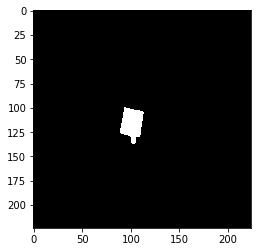

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


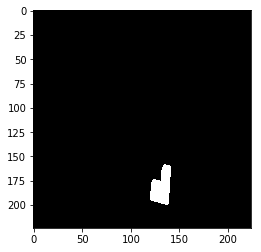

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


IndexError: index 2 is out of bounds for axis 2 with size 2

In [4]:
# Plots the images in jupyter notebook for comparison
#y = y/255
#showImage(x[600], cmap='gray')

plt.imshow(y[4][:,:,0], cmap = 'gray')
plt.show()
print(np.amax(y[4][:,:,0], axis=1))

plt.imshow(y[4][:,:,1], cmap = 'gray')
plt.show()

print(np.amax(y[4][:,:,1], axis=1))

plt.imshow(y[4][:,:,2], cmap = 'gray')
plt.show()

In [5]:
print(y.shape)

(3064, 224, 224, 2)


In [5]:
# Defining the loss function 
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1. - intersection)

def iou_loss(y_true, y_pred):
    return  -iou(y_true, y_pred)

def f1(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_np(y_true, y_pred):
    return (2. * (y_true * y_pred).sum() + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def f1_loss(y_true, y_pred):
    return 1-f1(y_true, y_pred)

def precision(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_pred_f) + 1.)

def precision_np(y_true, y_pred):
    return ((y_true * y_pred).sum() + 1.) / (y_pred.sum() + 1.)

def recall(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_true_f) + 1.)

def recall_np(y_true, y_pred):
    return ((y_true * y_pred).sum() + 1.) / (y_true.sum() + 1.)

def mae_img(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return mae(y_true_f, y_pred_f)

def bce_img(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return binary_crossentropy(y_true_f, y_pred_f)

def f1_bce(y_true, y_pred):
    return f1_loss(y_true, y_pred) + bce_img(y_true, y_pred)

# FP + FN
def error(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.sum(K.abs(y_true_f - y_pred_f)) / float(224*224)

def error_np(y_true, y_pred):
    return (abs(y_true - y_pred)).sum() / float(len(y_true.flatten()))

#Altes Modell laden
from keras.models import load_model
model = load_model('modelsave2.h5', custom_objects={'iou_loss': iou_loss})

model.summary()

In [6]:
from unet import UNet
model = None
model = UNet((224,224,1), 2, 16, 4, 2.0)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [7]:
model.compile(optimizer=Adam(lr=0.0001), loss=f1_loss, metrics=[iou_loss, precision, error,recall])

In [12]:
train = 2450 # = 80% of all given data  
model.fit(x[:train], y[:train], batch_size=32, epochs=15,
         validation_data=(x[train:], y[train:]), shuffle=True)

Train on 2450 samples, validate on 614 samples
Epoch 1/15
2450/2450 [==============================] - 22s 9ms/step - loss: 0.3988 - iou_loss: -0.4306 - precision: 0.8168 - error: 0.4060 - recall: 0.4776 - val_loss: 0.4031 - val_iou_loss: -0.4264 - val_precision: 0.7908 - val_error: 0.4333 - val_recall: 0.4810
Epoch 2/15
2450/2450 [==============================] - 22s 9ms/step - loss: 0.3930 - iou_loss: -0.4366 - precision: 0.8279 - error: 0.3991 - recall: 0.4807 - val_loss: 0.4006 - val_iou_loss: -0.4289 - val_precision: 0.7918 - val_error: 0.4319 - val_recall: 0.4840
Epoch 3/15
2450/2450 [==============================] - 22s 9ms/step - loss: 0.3884 - iou_loss: -0.4412 - precision: 0.8332 - error: 0.3944 - recall: 0.4850 - val_loss: 0.4173 - val_iou_loss: -0.4120 - val_precision: 0.7134 - val_error: 0.4723 - val_recall: 0.4944
Epoch 4/15
2450/2450 [==============================] - 22s 9ms/step - loss: 0.3893 - iou_loss: -0.4404 - precision: 0.8374 - error: 0.3945 - recall: 0.4834 -

In [9]:
z = read_imgs('/home/dan/Desktop/Datenset_TowerBuilding/test/images/data/*.png', (224,224,1))
k = read_imgs('/home/dan/Desktop/Datenset_TowerBuilding/test/masks/data/*.png', (224,224,1))

/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800


In [10]:
# makes a prediction for the whole dataset
pred = model.predict(z, verbose=1)

3922/3922 [==============================] - 12s 3ms/step


In [10]:
print(pred.shape)

(3064, 224, 224, 2)


NameError: name 'testPred' is not defined

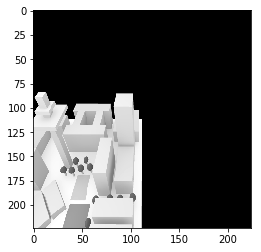

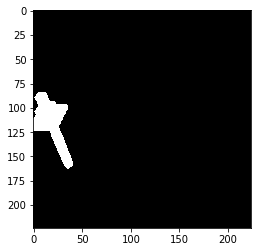

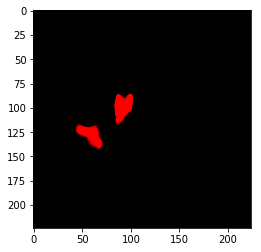

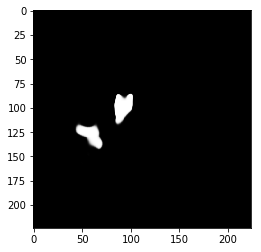

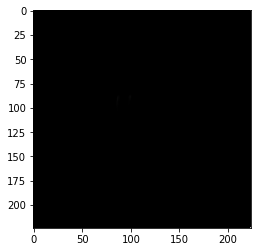

In [11]:
# Plots the prediction in jupyter notebook for comparison
i = 420

# Input Picture
plt.imshow(z[i, ..., 0], cmap='gray')
plt.show()

# Ground Truth
plt.imshow(k[i][:,:,0], cmap = 'gray')
plt.show()

# RGB Bild
rg = np.concatenate([pred[i], np.zeros((224,224,1))], axis=2)
plt.imshow(rg)
plt.show()

# Prediction Dim 0
plt.imshow(pred[i][:,:,0], cmap = 'gray')
plt.show()

# Prediction Dim 1
plt.imshow(pred[i][:,:,1], cmap = 'gray')
plt.show()



#plt.imshow(pred[i][:,:,2], cmap = 'gray')
#plt.show()

#plt.imshow(k[i][:,:,2], cmap = 'gray')
#plt.show()

#plt.imshow(y[i, ..., 0], cmap='gray')
#plt.show()
#plt.imshow(pred[i, ..., 0], cmap='gray')
#plt.show()

In [89]:
l = pred[55]
m = np.zeros((224,224,1))
arr = np.concatenate([l,m], axis=2)
io.imsave("teeest.png",arr)

/home/dan/.conda/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Save the Model
Speichert
* die Architektur
* die Gewichte
* die Trainingskonfigurationen (loss, optimizer)
* State des Optimizers

In [14]:
model.save('ds1_1_small.h5')